In [42]:
# Importing the necessary packages
import numpy as np
import torch
import torchvision
import torch.nn            as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.datasets   as torch_datasets
import torchvision.transforms as transforms
import matplotlib.pyplot      as plt
from   torch.utils.data   import Dataset
from   torchsummary       import summary
from   tqdm  import tqdm

In [64]:
# ----------- Creating a Train and Test Dataset ----------------

# Transformation to be applied to the images before giving as input to model
transformations = transforms.Compose([transforms.ToTensor()
                                    , transforms.Normalize((0.1751,), (0.3332,))])# The mean and standard deviation for EMNIST data (balanced)

# Creating a training dataset from EMNIST Balanced:  131,600 characters. 47 balanced classes.
train_set = torch_datasets.EMNIST('../data_emnist', split='byclass'
                          , train=True, download=True
                          , transform = transformations)

test_set  = torch_datasets.EMNIST('../data_emnist', split='byclass'
                          , train=False, download=True
                          , transform = transformations)

In [65]:
'''
    This block is run for a batch_size = len(train_set), to get mean and std of the training images
    BEFORE normalization is applied to the dataset, after .ToTensor() method squishes 0-255 range of pixel
    values between 0-1
'''
# for images,target in train_loader:
#     mean_images = (images).mean()
#     std_images  = (images).std()
# print("Mean of images = {}".format(mean_images))   # Mean =  0.17510417103767395
# print("Standard deviation of images = {}".format(std_images)) # std = 0.3332371413707733

'\n    This block is run for a batch_size = len(train_set), to get mean and std of the training images\n    BEFORE normalization is applied to the dataset, after .ToTensor() method squishes 0-255 range of pixel\n    values between 0-1\n'

In [66]:
'''
    This block is to assert whether both training and test sets have the same number/type of 
    classes (with the same labelling) for classification, and assign the number to a variable 
    'num_classes' which will be equal to the number of kernel that will be used later in the 
    final convolution layer, just before the GlobalAveragePooling (gap) layer in the NeuralNetwork.
 '''
classes_in_train = train_set.targets.unique().numpy()
classes_in_test  = test_set.targets.unique().numpy()
assert np.isin(classes_in_test,classes_in_train).all()

num_classes = len(train_set.targets.unique().numpy())
print(f'Number of classes: {num_classes}')

Number of classes: 62


In [67]:
class NeuralNet(nn.Module):
    def __init__(self):
        super(NeuralNet, self).__init__()
        '''RF formula: 
           RF[n] = RF[n-1] + (kernel_size - 1) * j[n-1], where:- 
           RF[k] is the receptive field of k'th layer and j[k] is the jump (cumulative stride)
           j[n] = j[n-1] * stride[n-1]
           j[1] = 1 and RF[1]=1
        '''
        # Input layer (image): | RF: 1  | j[0] = 1
        self.conv1 = nn.Conv2d(1 , 10, 3, padding=1) # Input: 28x28x1  | Output: 28x28x10 | RF:3  | j[1] = j[2]*1 = 1
        self.conv2 = nn.Conv2d(10, 10, 3, padding=1) # Input: 28x28x10 | Output: 28x28x10 | RF:5  | j[2] = j[3]*1 = 1
        self.pool1 = nn.MaxPool2d(2, 2)              # Input: 28x28x10 | Output: 14x14x10 | RF:6  | j[3] = j[4]*2 = 2
        '''
        For self.pool1 (layer[3]): j[3] = j[2]*stride = 1 * 2 = 2
        '''
        self.conv3 = nn.Conv2d(10, 20, 3, padding=1) # Input: 14x14x10 | Output: 14x14x20 | RF:10  | j[4] = j[3]*1 = 2
        self.conv4 = nn.Conv2d(20, 20, 3, padding=1) # Input: 14x14x20 | Output: 14x14x20 | RF:14  | j[5] = j[4]*1 = 2
        self.pool2 = nn.MaxPool2d(2, 2)              # Input: 14x14x20 | Output: 7x7x20   | RF:16  | j[6] = j[4]*2 = 4
        '''
        For self.pool2 (layer[6]): j[6] = j[5]*stride = 2 * 2 = 4
        '''
        self.conv5 = nn.Conv2d(20, 30, 3)            # Input: 7x7x20   | Output: 5x5x30   | RF:24  | j[7] = j[6]*1 = 4
        self.conv6 = nn.Conv2d(30, num_classes, 3)   # Input: 5x5x30   | Output: 3x3x62   | RF:32  | j[8] = j[6]*1 = 4
        self.gap   = nn.AvgPool2d(3)                 # Input: 3x3x62   | Output: 1x1x62   | RF:40  | j[8] = j[6]*3 = 12

    def forward(self, x):
        x = self.pool1(F.relu(self.conv2(F.relu(self.conv1(x)))))
        x = self.pool2(F.relu(self.conv4(F.relu(self.conv3(x)))))
        x = self.conv6(F.relu(self.conv5(x)))
        x = self.gap(x)
        x = x.view(-1, num_classes)
        return F.log_softmax(x,dim=1)

In [68]:
use_cuda = torch.cuda.is_available()                   # Checks if Cuda is available, and returns True if yes
device   = torch.device("cuda" if use_cuda else "cpu") # Selects whether to load and train on GPU or CPU
model    = NeuralNet().to(device)                      # Loads the model weights on the gpu or cpu
summary(model, input_size=(1, 28, 28))                 # Shows the sizes of the input and output at each layers for a given input image size, and total parameters

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 28, 28]             100
            Conv2d-2           [-1, 10, 28, 28]             910
         MaxPool2d-3           [-1, 10, 14, 14]               0
            Conv2d-4           [-1, 20, 14, 14]           1,820
            Conv2d-5           [-1, 20, 14, 14]           3,620
         MaxPool2d-6             [-1, 20, 7, 7]               0
            Conv2d-7             [-1, 30, 5, 5]           5,430
            Conv2d-8             [-1, 62, 3, 3]          16,802
         AvgPool2d-9             [-1, 62, 1, 1]               0
Total params: 28,682
Trainable params: 28,682
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.21
Params size (MB): 0.11
Estimated Total Size (MB): 0.32
---------------------------------------------

In [69]:
# Creating data loaders to load samples from dataset (train or test)
torch.manual_seed(2020)   # Set Randomization seed for shuffle
batch_size   = 2048        # Set Batch size for each sample batch pulled by loaders
kwargs       = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

train_loader = torch.utils.data.DataLoader(train_set, batch_size = batch_size, shuffle=True, **kwargs)
test_loader  = torch.utils.data.DataLoader(test_set,  batch_size = batch_size, shuffle=True, **kwargs)

In [70]:
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    pbar = tqdm(train_loader,leave=False)
    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()  # Sets the gradients of all optimized torch.Tensors to zero. 
        # It’s important to call optimizer.zero_grad() before loss.backward(), otherwise gradients will be accumulated from multiple passes.
        output = model(data)                  # The feed forward pass for generating output from data
        loss   = F.nll_loss(output, target)   # Calculates the negative log likelihood loss for the given sets of output to predicted targets
        loss.backward()         # Calculates the d(loss)/dx for each parameter x, which are accumulated into x.grad
        optimizer.step()        # optimizer.step() multiples the learing rate with the x.grad and updates each model parameter
        string_name = 'Epoch={} | Batch_id={} | Loss={:.6f}'.format(epoch,batch_idx,loss.item())
        pbar.set_description(desc=string_name) # Updates the description at every timestep while showing the progress bar

    # Getting Training Accuracy
    model.eval()
    total_train_loss = 0
    correct_train = 0
    # torch.no_grad() disables gradient calculation during inference, thus reducing memory consumption 
    # by making sure tensor.Backward() is not called
    with torch.no_grad():
        for data, target in train_loader:
            data, target   = data.to(device), target.to(device)
            output         = model(data)
            total_train_loss += F.nll_loss(output, target, reduction='sum').item()  # sums up the loss for all samples in a batch
            pred           = output.argmax(dim=1, keepdim=True)                      # get the index of the max log-probability
            correct_train += pred.eq(target.view_as(pred)).sum().item()              # Compare the predictions with the target

    train_loss     = total_train_loss/len(train_loader.dataset)
    train_accuracy = 100. * (correct_train / len(train_loader.dataset))
    print('\nEpoch:{}\nTrain Set: Mean loss: {:.4f}, Train Accuracy: {}/{} ({:.1f}%)'.format(epoch,
        train_loss, correct_train, len(train_loader.dataset),train_accuracy))
    return train_loss,train_accuracy
    
def test(model, device, test_loader):
    model.eval()
    total_test_loss,correct_test = 0,0
    # torch.no_grad() disables gradient calculation during inference, thus reducing memory consumption 
    # by making sure tensor.Backward() is not called
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output       = model(data)
            total_test_loss += F.nll_loss(output, target, reduction='sum').item()  # sums up the loss for all samples in a batch
            pred         = output.argmax(dim=1, keepdim=True)                      # get the index of the max log-probability
            correct_test+= pred.eq(target.view_as(pred)).sum().item()              # Compare the predictions with the target

    test_loss = total_test_loss/len(test_loader.dataset)
    test_accuracy = 100. * (correct_test / len(test_loader.dataset))
    print('\nTest Set : Mean loss: {:.4f}, Test Accuracy : {}/{} ({:.1f}%)\n'.format(
        test_loss, correct_test, len(test_loader.dataset),test_accuracy))
    return test_loss,test_accuracy

In [71]:
LR = 0.005
optimizer = optim.SGD(model.parameters(), lr=LR, momentum=0.9)  # Applies mini-batch gradient descent for training

num_epochs   = 20
update_lr_ep = int(num_epochs*0.5)
'''
    update_lr_ep: epoch at which the Learning rate will be updated
   
    We will be reducing the learning rate by a factor of 10 after every (0.5*num_epochs = 10 epochs).
    (epoch starts from 0). A total reduction factor of 1000 in learning rate after 15 epochs. 
    This is so that the training loss does not plateau, which was seen when a fixed learning rate of 0.01 was used.
'''
train_loss_vals = []
train_acc_vals  = []
test_loss_vals  = []
test_acc_vals   = []
for epoch in range(0, num_epochs):

    if ((epoch + 1) % update_lr_ep) == 0:
        old_learn_rate = optimizer.param_groups[0]['lr']
        new_learn_rate = optimizer.param_groups[0]['lr']/10
        optimizer.param_groups[0]['lr'] = new_learn_rate
        print("\n--------------------------------------------------------")
        print("Learning rate updated from {} to {} at epoch {}!".format(old_learn_rate,new_learn_rate,epoch))
        print("--------------------------------------------------------\n")

    train_loss,train_acc = train(model, device, train_loader, optimizer, epoch)
    # A folder has been created to save the trained models at each epoch
    model_path = '../data_emnist/trained_models/emnist_classification_model_epoch_'+str(epoch)+'_batchsize_'+str(batch_size)+'_lr_'+str(LR)
    torch.save(model.state_dict(), model_path)

    test_loss,test_acc   = test(model, device, test_loader)

    train_loss_vals.append(train_loss)
    test_loss_vals.append(test_loss)
    train_acc_vals.append(train_acc)
    test_acc_vals.append(test_acc)

# model.load_state_dict(torch.load(model_path), strict=False)
# For loading the model saved at a particular epoch




  0%|          | 0/341 [00:00<?, ?it/s]


Epoch=0 | Batch_id=0 | Loss=4.125688:   0%|          | 0/341 [00:00<?, ?it/s]


Epoch=0 | Batch_id=0 | Loss=4.125688:   0%|          | 1/341 [00:00<03:08,  1.80it/s]


Epoch=0 | Batch_id=1 | Loss=4.122197:   0%|          | 1/341 [00:00<03:08,  1.80it/s]


Epoch=0 | Batch_id=1 | Loss=4.122197:   1%|          | 2/341 [00:00<02:49,  2.00it/s]


Epoch=0 | Batch_id=2 | Loss=4.123782:   1%|          | 2/341 [00:01<02:49,  2.00it/s]


Epoch=0 | Batch_id=2 | Loss=4.123782:   1%|          | 3/341 [00:01<02:33,  2.21it/s]


Epoch=0 | Batch_id=3 | Loss=4.124037:   1%|          | 3/341 [00:01<02:33,  2.21it/s]


Epoch=0 | Batch_id=3 | Loss=4.124037:   1%|          | 4/341 [00:01<02:23,  2.35it/s]


Epoch=0 | Batch_id=4 | Loss=4.123797:   1%|          | 4/341 [00:02<02:23,  2.35it/s]


Epoch=0 | Batch_id=4 | Loss=4.123797:   1%|▏         | 5/341 [00:02<02:18,  2.43it/s]


Epoch=0 | Batch_id=5 | Loss=4.123011:   1%|▏         | 5/341 [00:02<02:18,  2.43it/


Epoch:0
Train Set: Mean loss: 1.6013, Train Accuracy: 389233/697932 (55.8%)


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f5a09d6c828>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f5967b85f28>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    sel


Test Set : Mean loss: 1.5932, Test Accuracy : 64998/116323 (55.9%)






Epoch=1 | Batch_id=0 | Loss=1.646820:   0%|          | 0/341 [00:00<?, ?it/s]


Epoch=1 | Batch_id=0 | Loss=1.646820:   0%|          | 1/341 [00:00<03:05,  1.83it/s]


Epoch=1 | Batch_id=1 | Loss=1.598863:   0%|          | 1/341 [00:00<03:05,  1.83it/s]


Epoch=1 | Batch_id=1 | Loss=1.598863:   1%|          | 2/341 [00:00<02:44,  2.06it/s]


Epoch=1 | Batch_id=2 | Loss=1.675148:   1%|          | 2/341 [00:01<02:44,  2.06it/s]


Epoch=1 | Batch_id=2 | Loss=1.675148:   1%|          | 3/341 [00:01<02:31,  2.23it/s]


Epoch=1 | Batch_id=3 | Loss=1.488225:   1%|          | 3/341 [00:01<02:31,  2.23it/s]


Epoch=1 | Batch_id=3 | Loss=1.488225:   1%|          | 4/341 [00:01<02:21,  2.37it/s]


Epoch=1 | Batch_id=4 | Loss=1.598668:   1%|          | 4/341 [00:01<02:21,  2.37it/s]


Epoch=1 | Batch_id=4 | Loss=1.598668:   1%|▏         | 5/341 [00:01<02:16,  2.46it/s]


Epoch=1 | Batch_id=5 | Loss=1.592776:   1%|▏         | 5/341 [00:02<02:16,  2.46it/s]


Epoch=1 | Batch_id=5 | Loss=1.592776:


Epoch:1
Train Set: Mean loss: 0.7850, Train Accuracy: 526854/697932 (75.5%)


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f5a09d6c828>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f5967b85f28>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    sel


Test Set : Mean loss: 0.7813, Test Accuracy : 87880/116323 (75.5%)






Epoch=2 | Batch_id=0 | Loss=0.835936:   0%|          | 0/341 [00:00<?, ?it/s]


Epoch=2 | Batch_id=0 | Loss=0.835936:   0%|          | 1/341 [00:00<03:12,  1.77it/s]


Epoch=2 | Batch_id=1 | Loss=0.791359:   0%|          | 1/341 [00:00<03:12,  1.77it/s]


Epoch=2 | Batch_id=1 | Loss=0.791359:   1%|          | 2/341 [00:00<02:49,  1.99it/s]


Epoch=2 | Batch_id=2 | Loss=0.776344:   1%|          | 2/341 [00:01<02:49,  1.99it/s]


Epoch=2 | Batch_id=2 | Loss=0.776344:   1%|          | 3/341 [00:01<02:34,  2.19it/s]


Epoch=2 | Batch_id=3 | Loss=0.709635:   1%|          | 3/341 [00:01<02:34,  2.19it/s]


Epoch=2 | Batch_id=3 | Loss=0.709635:   1%|          | 4/341 [00:01<02:24,  2.34it/s]


Epoch=2 | Batch_id=4 | Loss=0.820574:   1%|          | 4/341 [00:01<02:24,  2.34it/s]


Epoch=2 | Batch_id=4 | Loss=0.820574:   1%|▏         | 5/341 [00:01<02:16,  2.47it/s]


Epoch=2 | Batch_id=5 | Loss=0.759735:   1%|▏         | 5/341 [00:02<02:16,  2.47it/s]


Epoch=2 | Batch_id=5 | Loss=0.759735:


Epoch:2
Train Set: Mean loss: 0.6402, Train Accuracy: 537975/697932 (77.1%)


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f5a09d6c828>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f5967b85f28>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    sel


Test Set : Mean loss: 0.6385, Test Accuracy : 89903/116323 (77.3%)






Epoch=3 | Batch_id=0 | Loss=0.658942:   0%|          | 0/341 [00:00<?, ?it/s]


Epoch=3 | Batch_id=0 | Loss=0.658942:   0%|          | 1/341 [00:00<03:02,  1.87it/s]


Epoch=3 | Batch_id=1 | Loss=0.614126:   0%|          | 1/341 [00:00<03:02,  1.87it/s]


Epoch=3 | Batch_id=1 | Loss=0.614126:   1%|          | 2/341 [00:00<02:40,  2.11it/s]


Epoch=3 | Batch_id=2 | Loss=0.623660:   1%|          | 2/341 [00:01<02:40,  2.11it/s]


Epoch=3 | Batch_id=2 | Loss=0.623660:   1%|          | 3/341 [00:01<02:27,  2.29it/s]


Epoch=3 | Batch_id=3 | Loss=0.650208:   1%|          | 3/341 [00:01<02:27,  2.29it/s]


Epoch=3 | Batch_id=3 | Loss=0.650208:   1%|          | 4/341 [00:01<02:20,  2.40it/s]


Epoch=3 | Batch_id=4 | Loss=0.640248:   1%|          | 4/341 [00:01<02:20,  2.40it/s]


Epoch=3 | Batch_id=4 | Loss=0.640248:   1%|▏         | 5/341 [00:01<02:11,  2.56it/s]


Epoch=3 | Batch_id=5 | Loss=0.622204:   1%|▏         | 5/341 [00:02<02:11,  2.56it/s]


Epoch=3 | Batch_id=5 | Loss=0.622204:


Epoch:3
Train Set: Mean loss: 0.5881, Train Accuracy: 554391/697932 (79.4%)


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f5a09d6c828>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f5967b85f28>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    sel


Test Set : Mean loss: 0.5886, Test Accuracy : 92443/116323 (79.5%)






Epoch=4 | Batch_id=0 | Loss=0.581081:   0%|          | 0/341 [00:00<?, ?it/s]


Epoch=4 | Batch_id=0 | Loss=0.581081:   0%|          | 1/341 [00:00<03:11,  1.78it/s]


Epoch=4 | Batch_id=1 | Loss=0.576572:   0%|          | 1/341 [00:00<03:11,  1.78it/s]


Epoch=4 | Batch_id=1 | Loss=0.576572:   1%|          | 2/341 [00:00<02:47,  2.02it/s]


Epoch=4 | Batch_id=2 | Loss=0.575528:   1%|          | 2/341 [00:01<02:47,  2.02it/s]


Epoch=4 | Batch_id=2 | Loss=0.575528:   1%|          | 3/341 [00:01<02:34,  2.19it/s]


Epoch=4 | Batch_id=3 | Loss=0.581929:   1%|          | 3/341 [00:01<02:34,  2.19it/s]


Epoch=4 | Batch_id=3 | Loss=0.581929:   1%|          | 4/341 [00:01<02:21,  2.39it/s]


Epoch=4 | Batch_id=4 | Loss=0.541458:   1%|          | 4/341 [00:01<02:21,  2.39it/s]


Epoch=4 | Batch_id=4 | Loss=0.541458:   1%|▏         | 5/341 [00:01<02:14,  2.49it/s]


Epoch=4 | Batch_id=5 | Loss=0.571824:   1%|▏         | 5/341 [00:02<02:14,  2.49it/s]


Epoch=4 | Batch_id=5 | Loss=0.571824:


Epoch:4
Train Set: Mean loss: 0.5527, Train Accuracy: 569635/697932 (81.6%)


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f5a09d6c828>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f5967b85f28>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    sel


Test Set : Mean loss: 0.5535, Test Accuracy : 94837/116323 (81.5%)






Epoch=5 | Batch_id=0 | Loss=0.510515:   0%|          | 0/341 [00:00<?, ?it/s]


Epoch=5 | Batch_id=0 | Loss=0.510515:   0%|          | 1/341 [00:00<03:03,  1.86it/s]


Epoch=5 | Batch_id=1 | Loss=0.506034:   0%|          | 1/341 [00:00<03:03,  1.86it/s]


Epoch=5 | Batch_id=1 | Loss=0.506034:   1%|          | 2/341 [00:00<02:41,  2.09it/s]


Epoch=5 | Batch_id=2 | Loss=0.587810:   1%|          | 2/341 [00:01<02:41,  2.09it/s]


Epoch=5 | Batch_id=2 | Loss=0.587810:   1%|          | 3/341 [00:01<02:26,  2.31it/s]


Epoch=5 | Batch_id=3 | Loss=0.569497:   1%|          | 3/341 [00:01<02:26,  2.31it/s]


Epoch=5 | Batch_id=3 | Loss=0.569497:   1%|          | 4/341 [00:01<02:17,  2.45it/s]


Epoch=5 | Batch_id=4 | Loss=0.534226:   1%|          | 4/341 [00:01<02:17,  2.45it/s]


Epoch=5 | Batch_id=4 | Loss=0.534226:   1%|▏         | 5/341 [00:01<02:08,  2.61it/s]


Epoch=5 | Batch_id=5 | Loss=0.562577:   1%|▏         | 5/341 [00:02<02:08,  2.61it/s]


Epoch=5 | Batch_id=5 | Loss=0.562577:


Epoch:5
Train Set: Mean loss: 0.5418, Train Accuracy: 574842/697932 (82.4%)


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f5a09d6c828>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f5967b85f28>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    sel


Test Set : Mean loss: 0.5439, Test Accuracy : 95776/116323 (82.3%)






Epoch=6 | Batch_id=0 | Loss=0.542249:   0%|          | 0/341 [00:00<?, ?it/s]


Epoch=6 | Batch_id=0 | Loss=0.542249:   0%|          | 1/341 [00:00<03:08,  1.81it/s]


Epoch=6 | Batch_id=1 | Loss=0.538087:   0%|          | 1/341 [00:00<03:08,  1.81it/s]


Epoch=6 | Batch_id=1 | Loss=0.538087:   1%|          | 2/341 [00:00<02:46,  2.04it/s]


Epoch=6 | Batch_id=2 | Loss=0.502634:   1%|          | 2/341 [00:01<02:46,  2.04it/s]


Epoch=6 | Batch_id=2 | Loss=0.502634:   1%|          | 3/341 [00:01<02:29,  2.26it/s]


Epoch=6 | Batch_id=3 | Loss=0.524663:   1%|          | 3/341 [00:01<02:29,  2.26it/s]


Epoch=6 | Batch_id=3 | Loss=0.524663:   1%|          | 4/341 [00:01<02:19,  2.41it/s]


Epoch=6 | Batch_id=4 | Loss=0.486112:   1%|          | 4/341 [00:01<02:19,  2.41it/s]


Epoch=6 | Batch_id=4 | Loss=0.486112:   1%|▏         | 5/341 [00:01<02:11,  2.55it/s]


Epoch=6 | Batch_id=5 | Loss=0.516518:   1%|▏         | 5/341 [00:02<02:11,  2.55it/s]


Epoch=6 | Batch_id=5 | Loss=0.516518:


Epoch:6
Train Set: Mean loss: 0.4988, Train Accuracy: 578292/697932 (82.9%)


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f5a09d6c828>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f5967b85f28>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    sel


Test Set : Mean loss: 0.5024, Test Accuracy : 96377/116323 (82.9%)






Epoch=7 | Batch_id=0 | Loss=0.483927:   0%|          | 0/341 [00:00<?, ?it/s]


Epoch=7 | Batch_id=0 | Loss=0.483927:   0%|          | 1/341 [00:00<02:59,  1.89it/s]


Epoch=7 | Batch_id=1 | Loss=0.523554:   0%|          | 1/341 [00:00<02:59,  1.89it/s]


Epoch=7 | Batch_id=1 | Loss=0.523554:   1%|          | 2/341 [00:00<02:39,  2.12it/s]


Epoch=7 | Batch_id=2 | Loss=0.520489:   1%|          | 2/341 [00:01<02:39,  2.12it/s]


Epoch=7 | Batch_id=2 | Loss=0.520489:   1%|          | 3/341 [00:01<02:27,  2.30it/s]


Epoch=7 | Batch_id=3 | Loss=0.485163:   1%|          | 3/341 [00:01<02:27,  2.30it/s]


Epoch=7 | Batch_id=3 | Loss=0.485163:   1%|          | 4/341 [00:01<02:16,  2.46it/s]


Epoch=7 | Batch_id=4 | Loss=0.501719:   1%|          | 4/341 [00:01<02:16,  2.46it/s]


Epoch=7 | Batch_id=4 | Loss=0.501719:   1%|▏         | 5/341 [00:01<02:07,  2.63it/s]


Epoch=7 | Batch_id=5 | Loss=0.518264:   1%|▏         | 5/341 [00:02<02:07,  2.63it/s]


Epoch=7 | Batch_id=5 | Loss=0.518264:


Epoch:7
Train Set: Mean loss: 0.4794, Train Accuracy: 582562/697932 (83.5%)


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f5a09d6c828>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f5967b85f28>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    sel


Test Set : Mean loss: 0.4842, Test Accuracy : 97011/116323 (83.4%)






Epoch=8 | Batch_id=0 | Loss=0.479844:   0%|          | 0/341 [00:00<?, ?it/s]


Epoch=8 | Batch_id=0 | Loss=0.479844:   0%|          | 1/341 [00:00<02:57,  1.92it/s]


Epoch=8 | Batch_id=1 | Loss=0.474541:   0%|          | 1/341 [00:00<02:57,  1.92it/s]


Epoch=8 | Batch_id=1 | Loss=0.474541:   1%|          | 2/341 [00:00<02:37,  2.16it/s]


Epoch=8 | Batch_id=2 | Loss=0.494107:   1%|          | 2/341 [00:01<02:37,  2.16it/s]


Epoch=8 | Batch_id=2 | Loss=0.494107:   1%|          | 3/341 [00:01<02:25,  2.33it/s]


Epoch=8 | Batch_id=3 | Loss=0.483753:   1%|          | 3/341 [00:01<02:25,  2.33it/s]


Epoch=8 | Batch_id=3 | Loss=0.483753:   1%|          | 4/341 [00:01<02:14,  2.50it/s]


Epoch=8 | Batch_id=4 | Loss=0.443940:   1%|          | 4/341 [00:01<02:14,  2.50it/s]


Epoch=8 | Batch_id=4 | Loss=0.443940:   1%|▏         | 5/341 [00:01<02:06,  2.66it/s]


Epoch=8 | Batch_id=5 | Loss=0.524517:   1%|▏         | 5/341 [00:02<02:06,  2.66it/s]


Epoch=8 | Batch_id=5 | Loss=0.524517:


Epoch:8
Train Set: Mean loss: 0.4646, Train Accuracy: 585550/697932 (83.9%)


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f5a09d6c828>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f5967b85f28>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    sel


Test Set : Mean loss: 0.4700, Test Accuracy : 97387/116323 (83.7%)


--------------------------------------------------------
Learning rate updated from 0.005 to 0.0005 at epoch 9!
--------------------------------------------------------






Epoch=9 | Batch_id=0 | Loss=0.442571:   0%|          | 0/341 [00:00<?, ?it/s]


Epoch=9 | Batch_id=0 | Loss=0.442571:   0%|          | 1/341 [00:00<02:57,  1.91it/s]


Epoch=9 | Batch_id=1 | Loss=0.454714:   0%|          | 1/341 [00:00<02:57,  1.91it/s]


Epoch=9 | Batch_id=1 | Loss=0.454714:   1%|          | 2/341 [00:00<02:39,  2.13it/s]


Epoch=9 | Batch_id=2 | Loss=0.453544:   1%|          | 2/341 [00:01<02:39,  2.13it/s]


Epoch=9 | Batch_id=2 | Loss=0.453544:   1%|          | 3/341 [00:01<02:24,  2.34it/s]


Epoch=9 | Batch_id=3 | Loss=0.499048:   1%|          | 3/341 [00:01<02:24,  2.34it/s]


Epoch=9 | Batch_id=3 | Loss=0.499048:   1%|          | 4/341 [00:01<02:13,  2.53it/s]


Epoch=9 | Batch_id=4 | Loss=0.492763:   1%|          | 4/341 [00:01<02:13,  2.53it/s]


Epoch=9 | Batch_id=4 | Loss=0.492763:   1%|▏         | 5/341 [00:01<02:08,  2.62it/s]


Epoch=9 | Batch_id=5 | Loss=0.460275:   1%|▏         | 5/341 [00:02<02:08,  2.62it/s]


Epoch=9 | Batch_id=5 | Loss=0.460275:


Epoch:9
Train Set: Mean loss: 0.4545, Train Accuracy: 587910/697932 (84.2%)


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f5a09d6c828>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f5967b85f28>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    sel


Test Set : Mean loss: 0.4591, Test Accuracy : 97888/116323 (84.2%)






Epoch=10 | Batch_id=0 | Loss=0.448330:   0%|          | 0/341 [00:00<?, ?it/s]


Epoch=10 | Batch_id=0 | Loss=0.448330:   0%|          | 1/341 [00:00<03:05,  1.83it/s]


Epoch=10 | Batch_id=1 | Loss=0.440396:   0%|          | 1/341 [00:00<03:05,  1.83it/s]


Epoch=10 | Batch_id=1 | Loss=0.440396:   1%|          | 2/341 [00:00<02:45,  2.05it/s]


Epoch=10 | Batch_id=2 | Loss=0.438836:   1%|          | 2/341 [00:01<02:45,  2.05it/s]


Epoch=10 | Batch_id=2 | Loss=0.438836:   1%|          | 3/341 [00:01<02:30,  2.25it/s]


Epoch=10 | Batch_id=3 | Loss=0.451158:   1%|          | 3/341 [00:01<02:30,  2.25it/s]


Epoch=10 | Batch_id=3 | Loss=0.451158:   1%|          | 4/341 [00:01<02:21,  2.39it/s]


Epoch=10 | Batch_id=4 | Loss=0.413234:   1%|          | 4/341 [00:01<02:21,  2.39it/s]


Epoch=10 | Batch_id=4 | Loss=0.413234:   1%|▏         | 5/341 [00:01<02:11,  2.55it/s]


Epoch=10 | Batch_id=5 | Loss=0.411226:   1%|▏         | 5/341 [00:02<02:11,  2.55it/s]


Epoch=10 | Batch_id=5 | Lo


Epoch:10
Train Set: Mean loss: 0.4539, Train Accuracy: 587867/697932 (84.2%)


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f5a09d6c828>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f5967b85f28>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    sel


Test Set : Mean loss: 0.4590, Test Accuracy : 97829/116323 (84.1%)






Epoch=11 | Batch_id=0 | Loss=0.465682:   0%|          | 0/341 [00:00<?, ?it/s]


Epoch=11 | Batch_id=0 | Loss=0.465682:   0%|          | 1/341 [00:00<02:58,  1.90it/s]


Epoch=11 | Batch_id=1 | Loss=0.422572:   0%|          | 1/341 [00:00<02:58,  1.90it/s]


Epoch=11 | Batch_id=1 | Loss=0.422572:   1%|          | 2/341 [00:00<02:38,  2.14it/s]


Epoch=11 | Batch_id=2 | Loss=0.497077:   1%|          | 2/341 [00:01<02:38,  2.14it/s]


Epoch=11 | Batch_id=2 | Loss=0.497077:   1%|          | 3/341 [00:01<02:25,  2.33it/s]


Epoch=11 | Batch_id=3 | Loss=0.452209:   1%|          | 3/341 [00:01<02:25,  2.33it/s]


Epoch=11 | Batch_id=3 | Loss=0.452209:   1%|          | 4/341 [00:01<02:17,  2.45it/s]


Epoch=11 | Batch_id=4 | Loss=0.462323:   1%|          | 4/341 [00:01<02:17,  2.45it/s]


Epoch=11 | Batch_id=4 | Loss=0.462323:   1%|▏         | 5/341 [00:01<02:09,  2.59it/s]


Epoch=11 | Batch_id=5 | Loss=0.464472:   1%|▏         | 5/341 [00:02<02:09,  2.59it/s]


Epoch=11 | Batch_id=5 | Lo


Epoch:11
Train Set: Mean loss: 0.4525, Train Accuracy: 588257/697932 (84.3%)


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f5a09d6c828>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f5967b85f28>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    sel


Test Set : Mean loss: 0.4577, Test Accuracy : 97904/116323 (84.2%)






Epoch=12 | Batch_id=0 | Loss=0.433617:   0%|          | 0/341 [00:00<?, ?it/s]


Epoch=12 | Batch_id=0 | Loss=0.433617:   0%|          | 1/341 [00:00<02:59,  1.90it/s]


Epoch=12 | Batch_id=1 | Loss=0.479376:   0%|          | 1/341 [00:00<02:59,  1.90it/s]


Epoch=12 | Batch_id=1 | Loss=0.479376:   1%|          | 2/341 [00:00<02:37,  2.15it/s]


Epoch=12 | Batch_id=2 | Loss=0.463144:   1%|          | 2/341 [00:01<02:37,  2.15it/s]


Epoch=12 | Batch_id=2 | Loss=0.463144:   1%|          | 3/341 [00:01<02:24,  2.34it/s]


Epoch=12 | Batch_id=3 | Loss=0.439121:   1%|          | 3/341 [00:01<02:24,  2.34it/s]


Epoch=12 | Batch_id=3 | Loss=0.439121:   1%|          | 4/341 [00:01<02:12,  2.55it/s]


Epoch=12 | Batch_id=4 | Loss=0.446947:   1%|          | 4/341 [00:01<02:12,  2.55it/s]


Epoch=12 | Batch_id=4 | Loss=0.446947:   1%|▏         | 5/341 [00:01<02:04,  2.69it/s]


Epoch=12 | Batch_id=5 | Loss=0.396938:   1%|▏         | 5/341 [00:02<02:04,  2.69it/s]


Epoch=12 | Batch_id=5 | Lo


Epoch:12
Train Set: Mean loss: 0.4527, Train Accuracy: 587982/697932 (84.2%)


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f5a09d6c828>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f5967b85f28>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    sel


Test Set : Mean loss: 0.4578, Test Accuracy : 97844/116323 (84.1%)






Epoch=13 | Batch_id=0 | Loss=0.467627:   0%|          | 0/341 [00:00<?, ?it/s]


Epoch=13 | Batch_id=0 | Loss=0.467627:   0%|          | 1/341 [00:00<02:59,  1.90it/s]


Epoch=13 | Batch_id=1 | Loss=0.454741:   0%|          | 1/341 [00:00<02:59,  1.90it/s]


Epoch=13 | Batch_id=1 | Loss=0.454741:   1%|          | 2/341 [00:00<02:40,  2.11it/s]


Epoch=13 | Batch_id=2 | Loss=0.461642:   1%|          | 2/341 [00:01<02:40,  2.11it/s]


Epoch=13 | Batch_id=2 | Loss=0.461642:   1%|          | 3/341 [00:01<02:25,  2.32it/s]


Epoch=13 | Batch_id=3 | Loss=0.423460:   1%|          | 3/341 [00:01<02:25,  2.32it/s]


Epoch=13 | Batch_id=3 | Loss=0.423460:   1%|          | 4/341 [00:01<02:16,  2.46it/s]


Epoch=13 | Batch_id=4 | Loss=0.494244:   1%|          | 4/341 [00:01<02:16,  2.46it/s]


Epoch=13 | Batch_id=4 | Loss=0.494244:   1%|▏         | 5/341 [00:01<02:08,  2.61it/s]


Epoch=13 | Batch_id=5 | Loss=0.439708:   1%|▏         | 5/341 [00:02<02:08,  2.61it/s]


Epoch=13 | Batch_id=5 | Lo


Epoch:13
Train Set: Mean loss: 0.4502, Train Accuracy: 588521/697932 (84.3%)


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f5a09d6c828>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f5967b85f28>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    sel


Test Set : Mean loss: 0.4553, Test Accuracy : 97977/116323 (84.2%)






Epoch=14 | Batch_id=0 | Loss=0.471667:   0%|          | 0/341 [00:00<?, ?it/s]


Epoch=14 | Batch_id=0 | Loss=0.471667:   0%|          | 1/341 [00:00<02:58,  1.91it/s]


Epoch=14 | Batch_id=1 | Loss=0.423907:   0%|          | 1/341 [00:00<02:58,  1.91it/s]


Epoch=14 | Batch_id=1 | Loss=0.423907:   1%|          | 2/341 [00:00<02:40,  2.12it/s]


Epoch=14 | Batch_id=2 | Loss=0.457262:   1%|          | 2/341 [00:01<02:40,  2.12it/s]


Epoch=14 | Batch_id=2 | Loss=0.457262:   1%|          | 3/341 [00:01<02:25,  2.33it/s]


Epoch=14 | Batch_id=3 | Loss=0.439942:   1%|          | 3/341 [00:01<02:25,  2.33it/s]


Epoch=14 | Batch_id=3 | Loss=0.439942:   1%|          | 4/341 [00:01<02:15,  2.48it/s]


Epoch=14 | Batch_id=4 | Loss=0.471717:   1%|          | 4/341 [00:01<02:15,  2.48it/s]


Epoch=14 | Batch_id=4 | Loss=0.471717:   1%|▏         | 5/341 [00:01<02:09,  2.60it/s]


Epoch=14 | Batch_id=5 | Loss=0.452803:   1%|▏         | 5/341 [00:02<02:09,  2.60it/s]


Epoch=14 | Batch_id=5 | Lo


Epoch:14
Train Set: Mean loss: 0.4495, Train Accuracy: 588680/697932 (84.3%)


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f5a09d6c828>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f5967b85f28>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    sel


Test Set : Mean loss: 0.4544, Test Accuracy : 97993/116323 (84.2%)






Epoch=15 | Batch_id=0 | Loss=0.417806:   0%|          | 0/341 [00:00<?, ?it/s]


Epoch=15 | Batch_id=0 | Loss=0.417806:   0%|          | 1/341 [00:00<02:54,  1.95it/s]


Epoch=15 | Batch_id=1 | Loss=0.484501:   0%|          | 1/341 [00:00<02:54,  1.95it/s]


Epoch=15 | Batch_id=1 | Loss=0.484501:   1%|          | 2/341 [00:00<02:34,  2.20it/s]


Epoch=15 | Batch_id=2 | Loss=0.461188:   1%|          | 2/341 [00:01<02:34,  2.20it/s]


Epoch=15 | Batch_id=2 | Loss=0.461188:   1%|          | 3/341 [00:01<02:21,  2.38it/s]


Epoch=15 | Batch_id=3 | Loss=0.448022:   1%|          | 3/341 [00:01<02:21,  2.38it/s]


Epoch=15 | Batch_id=3 | Loss=0.448022:   1%|          | 4/341 [00:01<02:12,  2.54it/s]


Epoch=15 | Batch_id=4 | Loss=0.434789:   1%|          | 4/341 [00:01<02:12,  2.54it/s]


Epoch=15 | Batch_id=4 | Loss=0.434789:   1%|▏         | 5/341 [00:01<02:05,  2.68it/s]


Epoch=15 | Batch_id=5 | Loss=0.437360:   1%|▏         | 5/341 [00:02<02:05,  2.68it/s]


Epoch=15 | Batch_id=5 | Lo


Epoch:15
Train Set: Mean loss: 0.4488, Train Accuracy: 588791/697932 (84.4%)


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f5a09d6c828>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f5967b85f28>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    sel


Test Set : Mean loss: 0.4541, Test Accuracy : 98029/116323 (84.3%)






Epoch=16 | Batch_id=0 | Loss=0.434456:   0%|          | 0/341 [00:00<?, ?it/s]


Epoch=16 | Batch_id=0 | Loss=0.434456:   0%|          | 1/341 [00:00<02:54,  1.95it/s]


Epoch=16 | Batch_id=1 | Loss=0.441797:   0%|          | 1/341 [00:00<02:54,  1.95it/s]


Epoch=16 | Batch_id=1 | Loss=0.441797:   1%|          | 2/341 [00:00<02:35,  2.18it/s]


Epoch=16 | Batch_id=2 | Loss=0.441641:   1%|          | 2/341 [00:01<02:35,  2.18it/s]


Epoch=16 | Batch_id=2 | Loss=0.441641:   1%|          | 3/341 [00:01<02:20,  2.40it/s]


Epoch=16 | Batch_id=3 | Loss=0.450401:   1%|          | 3/341 [00:01<02:20,  2.40it/s]


Epoch=16 | Batch_id=3 | Loss=0.450401:   1%|          | 4/341 [00:01<02:10,  2.59it/s]


Epoch=16 | Batch_id=4 | Loss=0.470854:   1%|          | 4/341 [00:01<02:10,  2.59it/s]


Epoch=16 | Batch_id=4 | Loss=0.470854:   1%|▏         | 5/341 [00:01<02:04,  2.71it/s]


Epoch=16 | Batch_id=5 | Loss=0.466334:   1%|▏         | 5/341 [00:02<02:04,  2.71it/s]


Epoch=16 | Batch_id=5 | Lo


Epoch:16
Train Set: Mean loss: 0.4476, Train Accuracy: 588924/697932 (84.4%)


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f5a09d6c828>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f5967b85f28>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    sel


Test Set : Mean loss: 0.4530, Test Accuracy : 98030/116323 (84.3%)






Epoch=17 | Batch_id=0 | Loss=0.474568:   0%|          | 0/341 [00:00<?, ?it/s]


Epoch=17 | Batch_id=0 | Loss=0.474568:   0%|          | 1/341 [00:00<02:57,  1.92it/s]


Epoch=17 | Batch_id=1 | Loss=0.484872:   0%|          | 1/341 [00:00<02:57,  1.92it/s]


Epoch=17 | Batch_id=1 | Loss=0.484872:   1%|          | 2/341 [00:00<02:39,  2.12it/s]


Epoch=17 | Batch_id=2 | Loss=0.475287:   1%|          | 2/341 [00:01<02:39,  2.12it/s]


Epoch=17 | Batch_id=2 | Loss=0.475287:   1%|          | 3/341 [00:01<02:23,  2.36it/s]


Epoch=17 | Batch_id=3 | Loss=0.422172:   1%|          | 3/341 [00:01<02:23,  2.36it/s]


Epoch=17 | Batch_id=3 | Loss=0.422172:   1%|          | 4/341 [00:01<02:13,  2.52it/s]


Epoch=17 | Batch_id=4 | Loss=0.455098:   1%|          | 4/341 [00:01<02:13,  2.52it/s]


Epoch=17 | Batch_id=4 | Loss=0.455098:   1%|▏         | 5/341 [00:01<02:06,  2.65it/s]


Epoch=17 | Batch_id=5 | Loss=0.451314:   1%|▏         | 5/341 [00:02<02:06,  2.65it/s]


Epoch=17 | Batch_id=5 | Lo


Epoch:17
Train Set: Mean loss: 0.4466, Train Accuracy: 589173/697932 (84.4%)


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f5a09d6c828>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f5967b85f28>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    sel


Test Set : Mean loss: 0.4520, Test Accuracy : 98034/116323 (84.3%)






Epoch=18 | Batch_id=0 | Loss=0.422732:   0%|          | 0/341 [00:00<?, ?it/s]


Epoch=18 | Batch_id=0 | Loss=0.422732:   0%|          | 1/341 [00:00<02:59,  1.90it/s]


Epoch=18 | Batch_id=1 | Loss=0.453977:   0%|          | 1/341 [00:00<02:59,  1.90it/s]


Epoch=18 | Batch_id=1 | Loss=0.453977:   1%|          | 2/341 [00:00<02:38,  2.14it/s]


Epoch=18 | Batch_id=2 | Loss=0.427214:   1%|          | 2/341 [00:01<02:38,  2.14it/s]


Epoch=18 | Batch_id=2 | Loss=0.427214:   1%|          | 3/341 [00:01<02:23,  2.36it/s]


Epoch=18 | Batch_id=3 | Loss=0.473221:   1%|          | 3/341 [00:01<02:23,  2.36it/s]


Epoch=18 | Batch_id=3 | Loss=0.473221:   1%|          | 4/341 [00:01<02:13,  2.53it/s]


Epoch=18 | Batch_id=4 | Loss=0.455644:   1%|          | 4/341 [00:01<02:13,  2.53it/s]


Epoch=18 | Batch_id=4 | Loss=0.455644:   1%|▏         | 5/341 [00:01<02:07,  2.63it/s]


Epoch=18 | Batch_id=5 | Loss=0.435392:   1%|▏         | 5/341 [00:02<02:07,  2.63it/s]


Epoch=18 | Batch_id=5 | Lo


Epoch:18
Train Set: Mean loss: 0.4458, Train Accuracy: 589368/697932 (84.4%)


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f5a09d6c828>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f5967b85f28>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    sel


Test Set : Mean loss: 0.4511, Test Accuracy : 98055/116323 (84.3%)


--------------------------------------------------------
Learning rate updated from 0.0005 to 5e-05 at epoch 19!
--------------------------------------------------------






Epoch=19 | Batch_id=0 | Loss=0.472103:   0%|          | 0/341 [00:00<?, ?it/s]


Epoch=19 | Batch_id=0 | Loss=0.472103:   0%|          | 1/341 [00:00<02:58,  1.91it/s]


Epoch=19 | Batch_id=1 | Loss=0.420450:   0%|          | 1/341 [00:00<02:58,  1.91it/s]


Epoch=19 | Batch_id=1 | Loss=0.420450:   1%|          | 2/341 [00:00<02:36,  2.16it/s]


Epoch=19 | Batch_id=2 | Loss=0.436791:   1%|          | 2/341 [00:01<02:36,  2.16it/s]


Epoch=19 | Batch_id=2 | Loss=0.436791:   1%|          | 3/341 [00:01<02:22,  2.37it/s]


Epoch=19 | Batch_id=3 | Loss=0.426271:   1%|          | 3/341 [00:01<02:22,  2.37it/s]


Epoch=19 | Batch_id=3 | Loss=0.426271:   1%|          | 4/341 [00:01<02:12,  2.55it/s]


Epoch=19 | Batch_id=4 | Loss=0.429393:   1%|          | 4/341 [00:01<02:12,  2.55it/s]


Epoch=19 | Batch_id=4 | Loss=0.429393:   1%|▏         | 5/341 [00:01<02:04,  2.69it/s]


Epoch=19 | Batch_id=5 | Loss=0.467408:   1%|▏         | 5/341 [00:02<02:04,  2.69it/s]


Epoch=19 | Batch_id=5 | Lo


Epoch:19
Train Set: Mean loss: 0.4443, Train Accuracy: 589879/697932 (84.5%)


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f5a09d6c828>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f5967b85f28>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    sel


Test Set : Mean loss: 0.4496, Test Accuracy : 98174/116323 (84.4%)



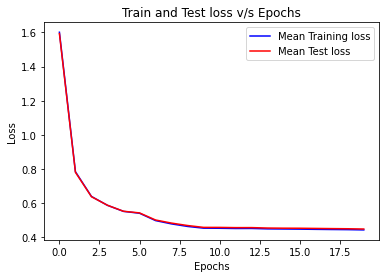

<Figure size 432x288 with 0 Axes>

In [72]:
epochs = range(0,num_epochs)
plt.plot(epochs, train_loss_vals, 'b', label='Mean Training loss')
plt.plot(epochs, test_loss_vals , 'r', label='Mean Test loss')
plt.title('Train and Test loss v/s Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
plt.savefig('../data_emnist/loss.png')

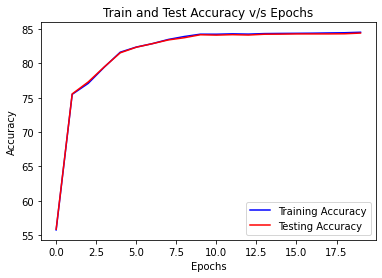

<Figure size 432x288 with 0 Axes>

In [78]:
plt.plot(epochs, train_acc_vals, 'b', label='Training Accuracy')
plt.plot(epochs, test_acc_vals, 'r', label='Testing Accuracy')
plt.title('Train and Test Accuracy v/s Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
plt.savefig('../data_emnist/accuracy.png')